# **个人贷款违约预测**

## 分析目标

本项目旨在通过应用不同的数据挖掘和机器学习模型，对个人贷款违约进行深入分析和预测，关键是看哪个模型的预测效果更好。通过对贷款申请人的贷款金额、期限、利率、贷款等级、违约记录等大量历史贷款数据的分析，以期识别出可能导致贷款违约的关键因素，并构建出有效的预测模型，预测借款者是否违约的可能性，以此判断是否通过此项贷款。进而辅助金融机构评估贷款申请的风险，优化信贷资源配置。

## 简介

 ### 背景
>在金融行业，向个人客户提供贷款是银行和金融机构的一项常规业务。随着个人贷款数量的逐渐增多，违约情况也相应变得较为常见。当借款人未能按时偿还贷款时，这不仅会导致金融机构面临经济损失，还可能损害其声誉和市场竞争地位。因此，对于金融机构而言，能够准确评估和预测个人贷款违约的可能性至关重要，这有助于更好地管理风险并做出明智的信贷决策。

  ### 数据信息
> 数据取于[阿里云天池](https://tianchi.aliyun.com/dataset/168012)，来自某信贷平台的贷款记录，总数据量超过100万条，从中抽取80万条作为训练集，20万条作为测试集A。每条数据包含47列变量信息，其中15列为匿名变量。
> 因为这是一个二元分类问题，所以因变量应为一个布尔值或者二分类标签，以表示借款人是否违约，而自变量则为贷款记录中的各项数据信息。

> 数据表中每列的含义如下：
> | Field             | Description                                                  |
|-------------------|--------------------------------------------------------------|
| id                | 为贷款清单分配的唯一信用证标识                             |
| loanAmnt          | 贷款金额                                                   |
| term              | 贷款期限（年）                                             |
| interestRate      | 贷款利率                                                   |
| installment       | 分期付款金额                                               |
| grade             | 贷款等级                                                   |
| subGrade          | 贷款等级之子级                                           |
| employmentTitle   | 就业职称                                                   |
| employmentLength  | 就业年限（年）                                             |
| homeOwnership     | 借款人在登记时提供的房屋所有权状况                         |
| annualIncome      | 年收入                                                     |
| verificationStatus| 验证状态                                                   |
| issueDate         | 贷款发放的月份                                             |
| purpose           | 借款人在贷款申请时的贷款用途类别                         |
| postCode          | 借款人在贷款申请中提供的邮政编码的前3位数字             |
| regionCode        | 地区编码                                                   |
| dti               | 债务收入比                                                 |
| delinquency_2years| 借款人过去2年信用档案中逾期30天以上的违约事件数         |
| ficoRangeLow      | 借款人在贷款发放时的fico所属的下限范围                 |
| ficoRangeHigh     | 借款人在贷款发放时的fico所属的上限范围                 |
| openAcc           | 借款人信用档案中未结信用额度的数量                     |
| pubRec            | 贬损公共记录的数量                                         |
| pubRecBankruptcies | 公开记录清除的数量                                         |
| revolBal         | 信贷周转余额合计                                           |
| revolUtil        | 循环额度利用率，或借款人使用的相对于所有可用循环信贷的信贷金额 |
| totalAcc          | 借款人信用档案中当前的信用额度总数                     |
| initialListStatus | 贷款的初始列表状态                                         |
| applicationType   | 表明贷款是个人申请还是与两个共同借款人的联合申请           |
| earliesCreditLine | 借款人最早报告的信用额度开立的月份                       |
| title             | 借款人提供的贷款名称                                     |
| policyCode        | 公开可用的策略_代码=1新产品不公开可用的策略_代码=2       |
| n系列匿名特征    | 匿名特征n0-n14，为一些贷款人行为计数特征的处理           |


## 读取数据

In [1]:
#导入所需要的库
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [2]:
# 读取数据
train = pd.read_csv("train.csv")

## 数据评估

In [3]:
#了解行数和列数情况
train.shape

(800000, 47)

In [4]:
#查看表格结构
train.head()

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,0,35000,5,19.52,917.97,E,E2,320.0,2 years,2,...,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,1,18000,5,18.49,461.90,D,D2,219843.0,5 years,0,...,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN
2,2,12000,5,16.99,298.17,D,D3,31698.0,8 years,0,...,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,3,11000,3,7.26,340.96,A,A4,46854.0,10+ years,1,...,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
4,4,3000,3,12.99,101.07,C,C2,54.0,NaN,1,...,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0


In [5]:
# 接下来通过info，对数据内容进行大致了解。
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  800000 non-null  int64  
 1   loanAmnt            800000 non-null  int64  
 2   term                800000 non-null  int64  
 3   interestRate        800000 non-null  float64
 4   installment         800000 non-null  float64
 5   grade               800000 non-null  object 
 6   subGrade            800000 non-null  object 
 7   employmentTitle     799999 non-null  float64
 8   employmentLength    753201 non-null  object 
 9   homeOwnership       800000 non-null  int64  
 10  annualIncome        800000 non-null  float64
 11  verificationStatus  800000 non-null  int64  
 12  issueDate           800000 non-null  object 
 13  isDefault           800000 non-null  int64  
 14  purpose             800000 non-null  int64  
 15  postCode            799999 non-nul

In [6]:
# 按数据特征分类
category_features = ['grade', 'subGrade', 'employmentLength', 'homeOwnership', 'verificationStatus', 'issueDate', 'purpose', 'postCode', 'regionCode', 'initialListStatus', 'applicationType', 'earliesCreditLine', 'title', 'policyCode']
numerical_features = ['loanAmnt', 'term', 'interestRate', 'installment', 'employmentTitle', 'annualIncome', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'pubRecBankruptcies', 'revolUtil', 'totalAcc']
anonymity_features = ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'n12', 'n13', 'n14']
y_feature = 'isDefault'

In [7]:
# 分类特征分布
for column in category_features:
    print(train[column].value_counts())

grade
B    233690
C    227118
A    139661
D    119453
E     55661
F     19053
G      5364
Name: count, dtype: int64
subGrade
C1    50763
B4    49516
B5    48965
B3    48600
C2    47068
C3    44751
C4    44272
B2    44227
B1    42382
C5    40264
A5    38045
A4    30928
D1    30538
D2    26528
A1    25909
D3    23410
A3    22655
A2    22124
D4    21139
D5    17838
E1    14064
E2    12746
E3    10925
E4     9273
E5     8653
F1     5925
F2     4340
F3     3577
F4     2859
F5     2352
G1     1759
G2     1231
G3      978
G4      751
G5      645
Name: count, dtype: int64
employmentLength
10+ years    262753
2 years       72358
< 1 year      64237
3 years       64152
1 year        52489
5 years       50102
4 years       47985
6 years       37254
8 years       36192
7 years       35407
9 years       30272
Name: count, dtype: int64
homeOwnership
0    395732
1    317660
2     86309
3       185
5        81
4        33
Name: count, dtype: int64
verificationStatus
1    309810
2    248968
0    241222

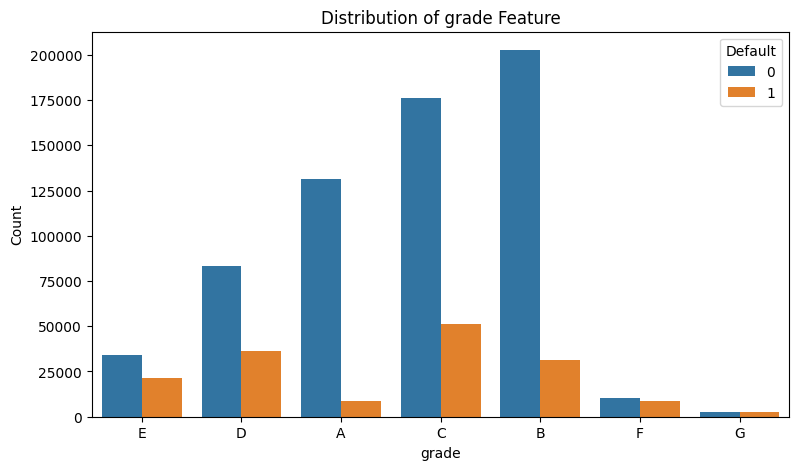

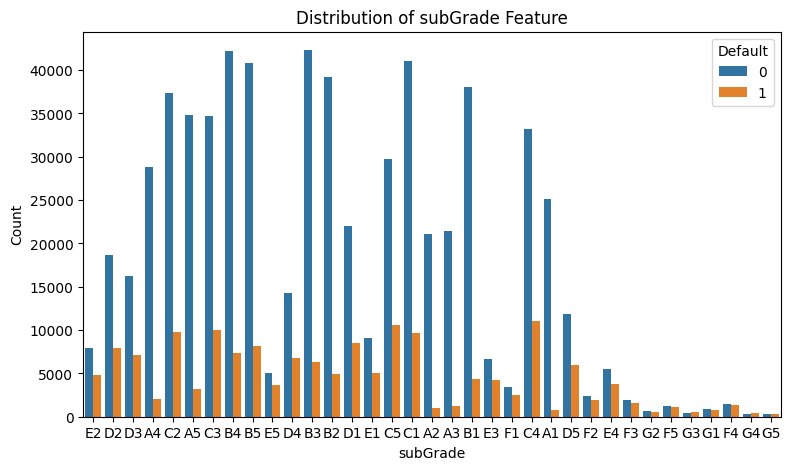

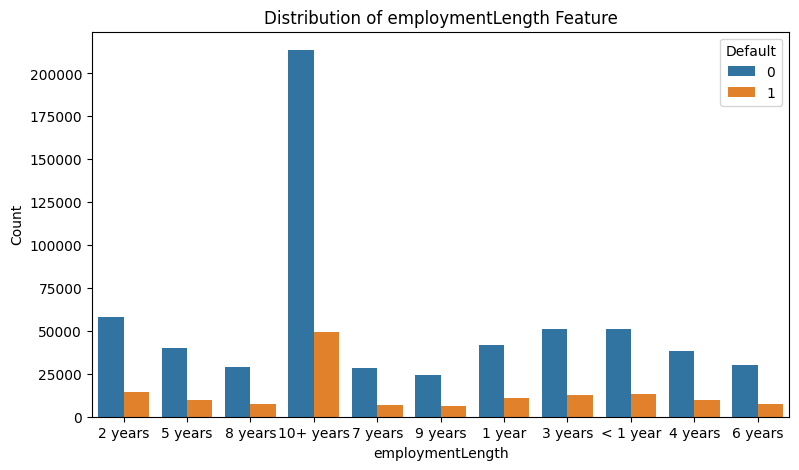

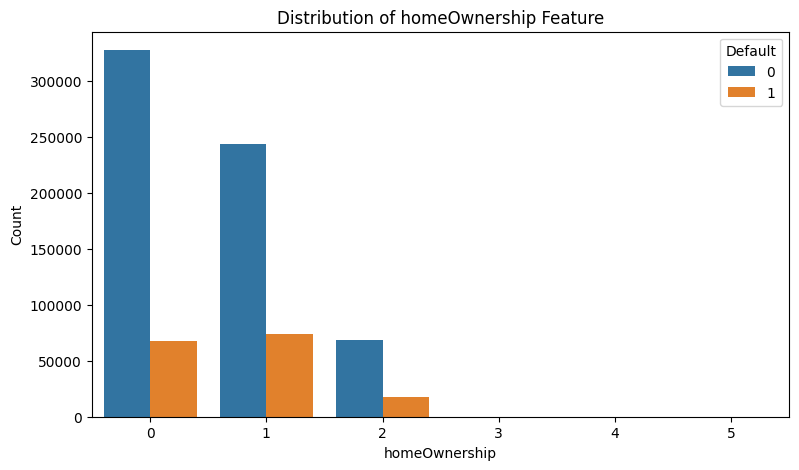

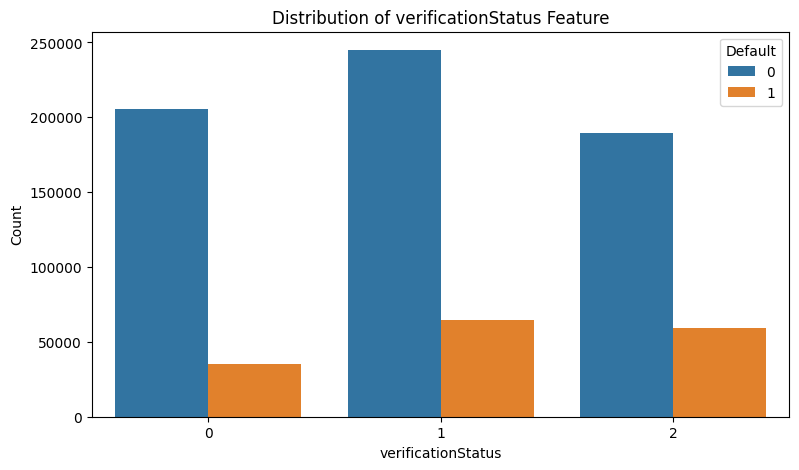

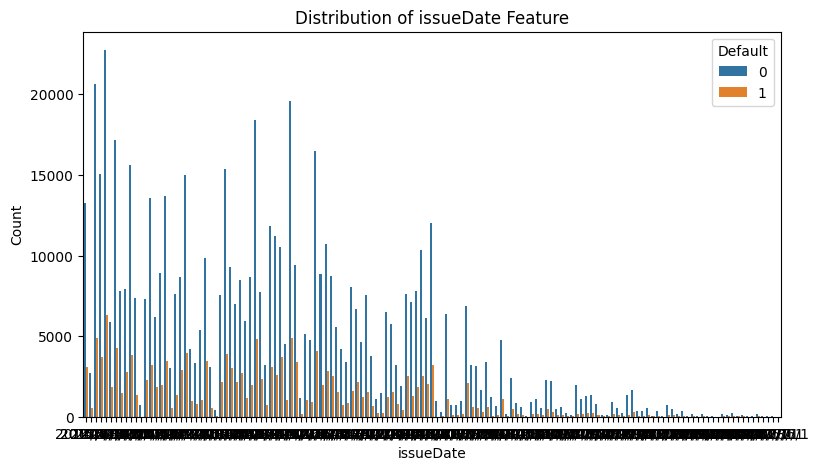

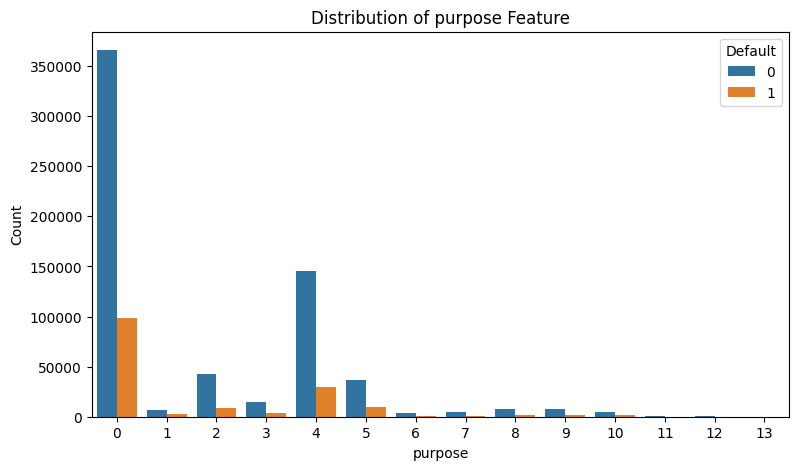

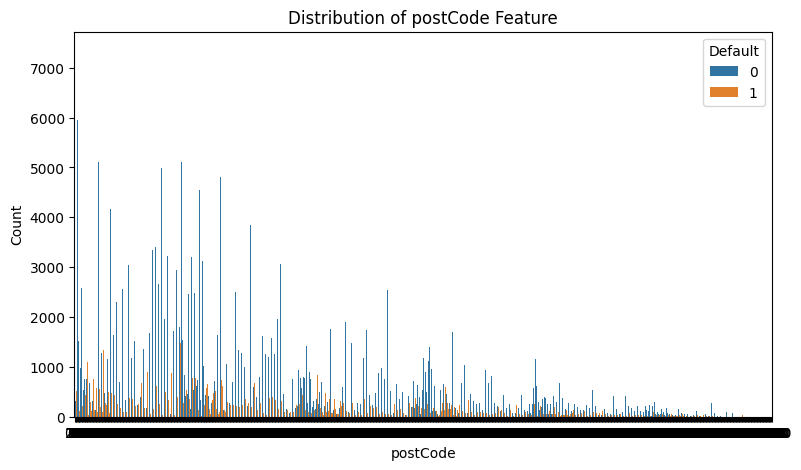

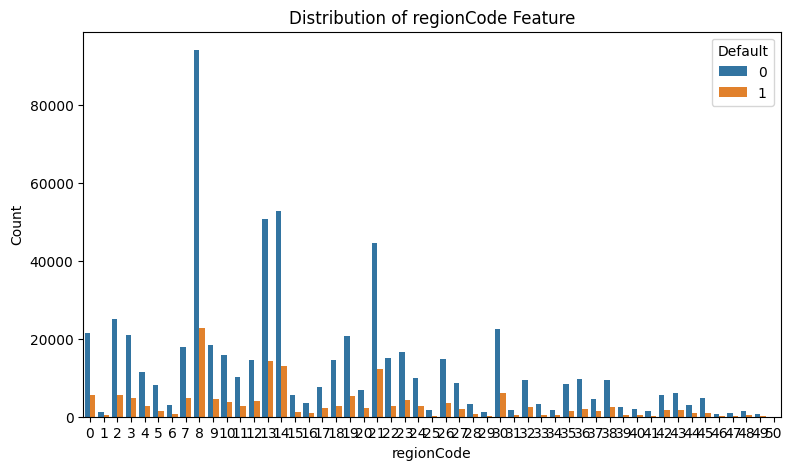

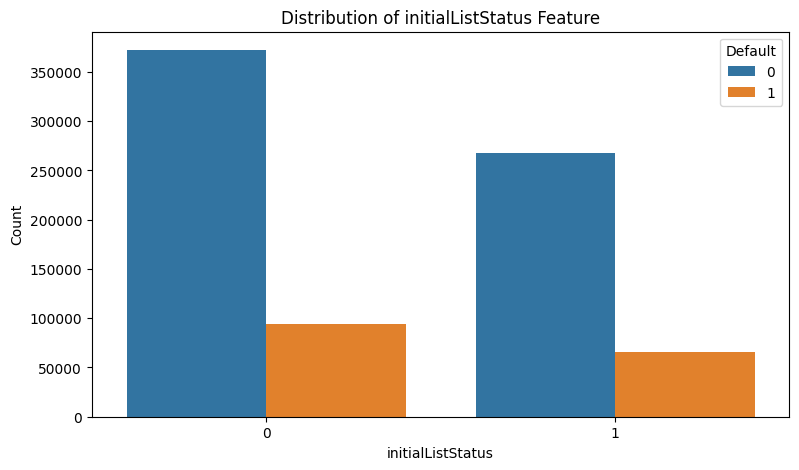

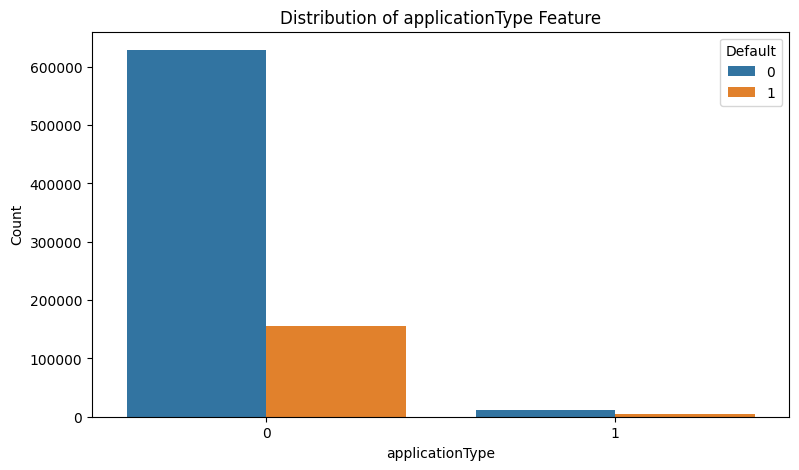

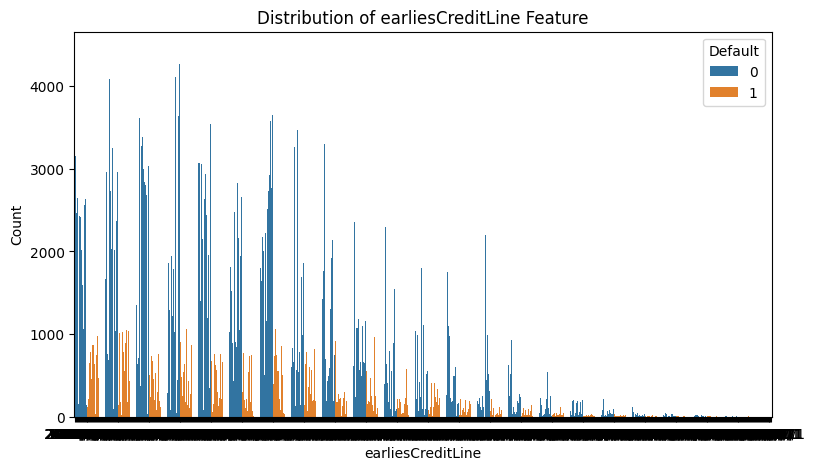

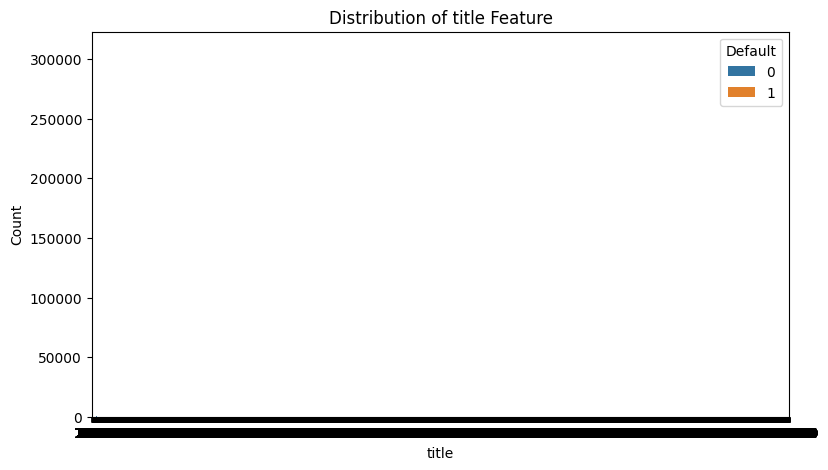

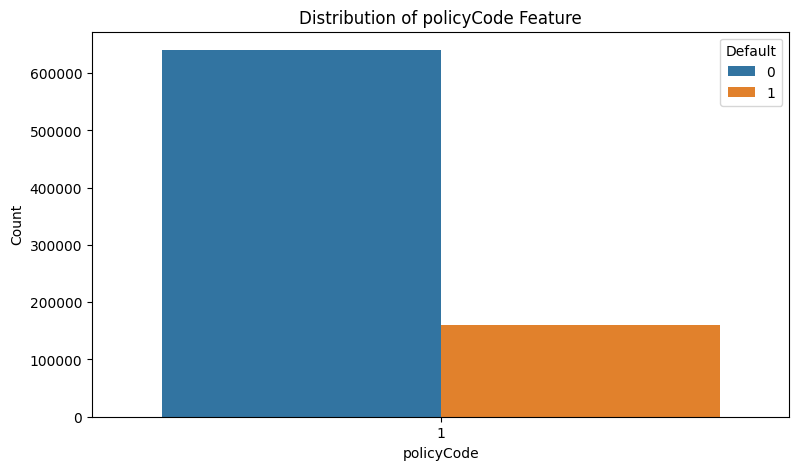

In [8]:
#查看分类特征分布图 
for feature in category_features:
    plt.figure(figsize=(9, 5))  # 
    sns.countplot(x=feature, hue='isDefault', data=train)
    plt.title(f'Distribution of {feature} Feature')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='Default', loc="upper right")
    plt.show()

In [9]:
# 查看类别型特征
train[category_features].head()

,grade,subGrade,employmentLength,homeOwnership,verificationStatus,issueDate,purpose,postCode,regionCode,initialListStatus,applicationType,earliesCreditLine,title,policyCode
0,E,E2,2 years,2,2,2014/7/1,1,137.0,32,0,0,2001/8/1,1.0,1
1,D,D2,5 years,0,2,2012/8/1,0,156.0,18,1,0,2002/5/1,1723.0,1
2,D,D3,8 years,0,2,2015/10/1,0,337.0,14,0,0,2006/5/1,0.0,1
3,A,A4,10+ years,1,1,2015/8/1,4,148.0,11,1,0,1999/5/1,4.0,1
4,C,C2,NaN,1,2,2016/3/1,10,301.0,21,0,0,1977/8/1,11.0,1


In [10]:
train[numerical_features].head()

,loanAmnt,term,interestRate,installment,employmentTitle,annualIncome,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolUtil,totalAcc
0,35000,5,19.52,917.97,320.0,110000.0,17.05,0,730,734,7,0,0.0,48.9,27
1,18000,5,18.49,461.90,219843.0,46000.0,27.83,0,700,704,13,0,0.0,38.9,18
2,12000,5,16.99,298.17,31698.0,74000.0,22.77,0,675,679,11,0,0.0,51.8,27
3,11000,3,7.26,340.96,46854.0,118000.0,17.21,0,685,689,9,0,0.0,52.6,28
4,3000,3,12.99,101.07,54.0,29000.0,32.16,0,690,694,12,0,0.0,32.0,27


In [11]:
train[anonymity_features].head()

,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,0.0,2.0,2.0,2.0,4.0,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN
2,0.0,0.0,3.0,3.0,0.0,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,6.0,4.0,6.0,6.0,4.0,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
4,1.0,2.0,7.0,7.0,2.0,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0


#### 缺失值

In [12]:
# 为了区分经过清理的数据和原始的数据，预先创建副本
cleaned_data = train.copy()

In [13]:
# 查看缺失率大于50%的特征。在样本足够的情况下，如果缺失率很大，表明这一列产生的影响几乎不起作用，可删；如果缺失值很小，则可填充
fea_null_moreThanHalf = {col: missing_rate for col, missing_rate in cleaned_data.isnull().mean().items() if missing_rate > 0.5}

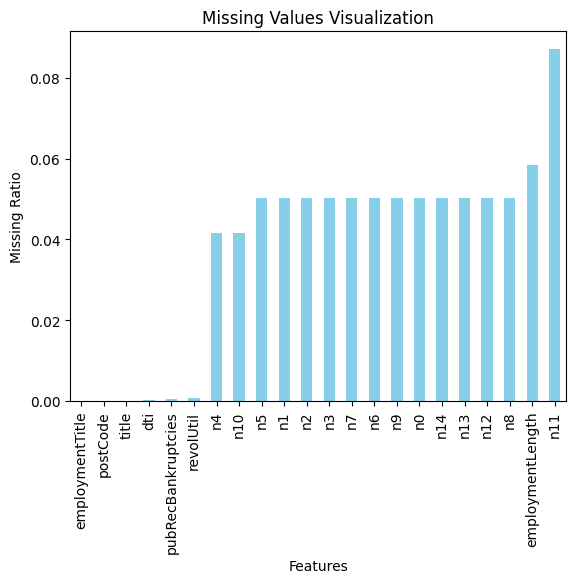

In [14]:
# nan可视化
import matplotlib.pyplot as plt

# nan可视化
missing = cleaned_data.isnull().sum() / len(cleaned_data)
missing = missing[missing > 0]  # 筛选出有缺失值的列
missing.sort_values(inplace=True)  # 按缺失值比例排序

# 绘制条形图
missing.plot.bar(color='skyblue')  # 指定条形图的颜色
plt.title('Missing Values Visualization')  # 添加图表标题
plt.xlabel('Features')  # x轴标签
plt.ylabel('Missing Ratio')  # y轴标签
plt.show()  # 显示图表

##### 缺失值评估
cleaned_data共有800000条观察值，其中employmentTitle、employmentLength、pubRecBankruptcies、revolUtil、title、dti和n0-n14共22列存在缺失值，实际情况中很正常，其中匿名变量n11列缺失值最大，但缺失率在0.1以下，没有需要删除的列

#### 唯一值（低方差特征）

In [15]:
 # 用 nunique() 函数计算每列的唯一值数量，如果这个数量小于或等于1，就将该列名添加到 one_value_fea 列表
one_value_fea = [col for col in cleaned_data.columns if cleaned_data[col].nunique() <= 1] 

 # 输出只含有一个唯一值的列的数量
print(f'There are {len(one_value_fea)} columns in train dataset with one unique value.') 
print(one_value_fea)

There are 1 columns in train dataset with one unique value.
['policyCode']


#### 唯一值评估
'PolicyCode'具有唯一值，在信贷数据中，PolicyCode 这一特征通常代表的是贷款策略代码，它可能指示了贷款产品是否为新推出的产品。policyCode 在某些数据集中只有一个值，例如值为1可能表示这是一个新产品，而值为2可能表示这不是一个新产品 。然而，PolicyCode 具有唯一值，这可能意味着数据集中所有贷款都遵循同一策略，或者该特征在数据集中没有变化，因此可能不携带有助于预测贷款违约风险的信息，后续选择删除。

## 数据处理

### 转化格式

In [16]:
# 表中有三个变量为日期格式,issueDate和earliesCreditLine分别表示贷款发放日期和最早的信用记录，employmentLength为年数

In [17]:
import pandas as pd
import numpy as np
from datetime import datetime

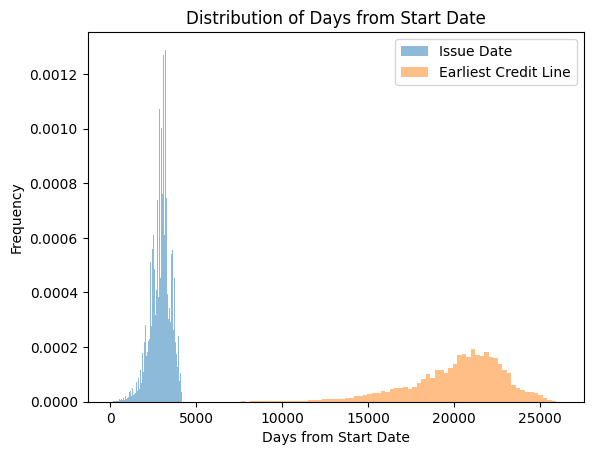

In [18]:
# 将变量日期转换格式
cleaned_data['issueDate'] = pd.to_datetime(cleaned_data['issueDate'], format='%Y/%m/%d')
startdate_issueDate = datetime.strptime('2007-06-01', '%Y-%m-%d')# issueDate一列最早日期为2007年6月1日以此为起始点转换时间格式
cleaned_data['issueDateDT'] = cleaned_data['issueDate'].apply(lambda x: (x - startdate_issueDate).days)

cleaned_data['earliesCreditLine'] = pd.to_datetime(cleaned_data['earliesCreditLine'], format='%Y/%m/%d')
startdate_earliesCreditLine = datetime.strptime('1944/01/01', '%Y/%m/%d')# earliesCreditLine一列最早日期为1944年1月1日以此为起始点转换时间格式
cleaned_data['earliesCreditLineDT'] = cleaned_data['earliesCreditLine'].apply(lambda x: (x - startdate_earliesCreditLine).days)
cleaned_data['earliesCreditLineDT_int'] = cleaned_data['earliesCreditLineDT'].astype(np.int64)

# 绘制直方图
plt.hist(cleaned_data['issueDateDT'], label='Issue Date', alpha=0.5, bins=100, density=True)
plt.hist(cleaned_data['earliesCreditLineDT'], label='Earliest Credit Line', alpha=0.5, bins=100, density=True)
plt.legend(loc='upper right')
plt.title('Distribution of Days from Start Date')
plt.xlabel('Days from Start Date')
plt.ylabel('Frequency')
plt.show()

直方图分析：
1.分布的集中性：变量issueDate的峰值分布集中在2500-3500间，对应年份为2014-2017年。earliesCreditLine的峰值集中在20000-22500间，对应年份1999-2005年。表明大多数贷款发行日期、最早的信用记录集中在特定的时间段内
2.分布形状：
3.分布的离散程度：issueDate的分布较窄，相对集中；earliesCreditLine的分布宽，表明数据点分布时间范围大
4.earliesCreditLine的分布尾部较长，表明包含一些非常早的日期，有可能是数据录入错误，或者存在特殊情况

In [19]:
def employmentLength_to_int(s):
    if pd.isnull(s):
      return np.nan  
    else:
        if isinstance(s, str):
            return int(float(s.split()[0]))
        else:
            return int(s)

for data in [cleaned_data]:
    data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)# 用replace方法将10+years去掉“+”
    data['employmentLength'].replace('< 1 year', '0 years', inplace=True)# 用 0 years替换 < 1 years，统一就业年限表示形式
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)# 将employmentLength字段的值转换为整数
    data['employmentLength'].value_counts(dropna=False).sort_index()# 计算 employmentLength 字段中每个值的出现次数，并按索引排序

print(data['employmentLength'].value_counts(dropna=False).sort_index())

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_14312\833251740.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)# 用replace方法将10+years去掉“+”
C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_14312\833251740.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate obje

employmentLength
0.0      64237
1.0      52489
2.0      72358
3.0      64152
4.0      47985
5.0      50102
6.0      37254
7.0      35407
8.0      36192
9.0      30272
10.0    262753
NaN      46799
Name: count, dtype: int64


### 缺失值补充

In [20]:
# 分类特征填充
for col in category_features:
    cleaned_data[col] = cleaned_data[col].fillna(cleaned_data[col].mode()[0])

# 数值型特征填充
for col in numerical_features:
    cleaned_data[col] = cleaned_data[col].fillna(cleaned_data[col].median())

# 匿名变量填充
for col in anonymity_features:
    mode_value = cleaned_data[col].mode()[0]  # 获取第一个众数
    cleaned_data[col] = cleaned_data[col].fillna(mode_value)

# 检查缺失值
print(cleaned_data.isnull().sum())


id                         0
loanAmnt                   0
term                       0
interestRate               0
installment                0
grade                      0
subGrade                   0
employmentTitle            0
employmentLength           0
homeOwnership              0
annualIncome               0
verificationStatus         0
issueDate                  0
isDefault                  0
purpose                    0
postCode                   0
regionCode                 0
dti                        0
delinquency_2years         0
ficoRangeLow               0
ficoRangeHigh              0
openAcc                    0
pubRec                     0
pubRecBankruptcies         0
revolBal                   0
revolUtil                  0
totalAcc                   0
initialListStatus          0
applicationType            0
earliesCreditLine          0
title                      0
policyCode                 0
n0                         0
n1                         0
n2            

### 删除无用列

In [21]:
cleaned_data = cleaned_data.drop('policyCode', axis=1)

### 异常值处理

In [22]:
def find_outliers_by_3segama(data,fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x:str('异常值') if x > upper_rule or x < lower_rule else '正常值')
    return data


In [23]:
for fea in numerical_features:
    new_data = find_outliers_by_3segama(cleaned_data,fea)
    print(cleaned_data[fea+'_outliers'].value_counts())
    print(cleaned_data.groupby(fea+'_outliers')['isDefault'].sum())
    print('*'*10)


loanAmnt_outliers
正常值    800000
Name: count, dtype: int64
loanAmnt_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
term_outliers
正常值    800000
Name: count, dtype: int64
term_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
interestRate_outliers
正常值    794259
异常值      5741
Name: count, dtype: int64
interestRate_outliers
异常值      2916
正常值    156694
Name: isDefault, dtype: int64
**********
installment_outliers
正常值    792046
异常值      7954
Name: count, dtype: int64
installment_outliers
异常值      2152
正常值    157458
Name: isDefault, dtype: int64
**********
employmentTitle_outliers
正常值    800000
Name: count, dtype: int64
employmentTitle_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
annualIncome_outliers
正常值    793973
异常值      6027
Name: count, dtype: int64
annualIncome_outliers
异常值       756
正常值    158854
Name: isDefault, dtype: int64
**********
dti_outliers
正常值    798440
异常值      1560
Name: count, dtype: int64
dti_outliers
异常值       466
正常值    1

In [24]:
for fea in numerical_features:
    if fea+'_outliers' in cleaned_data.columns:
        cleaned_data = cleaned_data[cleaned_data[fea+'_outliers'] == '正常值']
    else:

         print(f"Column {fea+'_outliers'} does not exist in cleaned_train.")
         cleaned_data = cleaned_data.reset_index(drop=True)



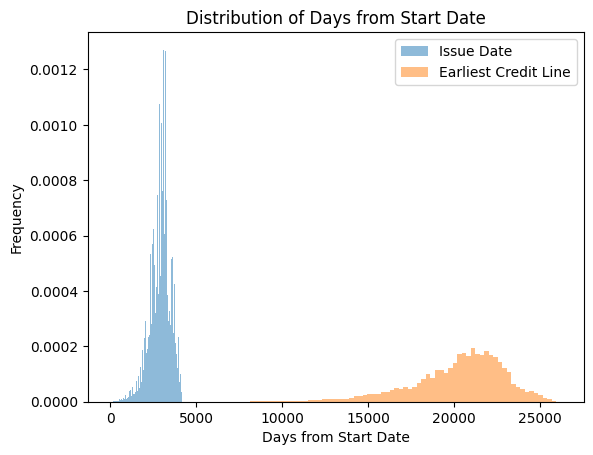

In [25]:
# 将变量日期转换格式
cleaned_data['issueDate'] = pd.to_datetime(cleaned_data['issueDate'], format='%Y/%m/%d')
startdate_issueDate = datetime.strptime('2007-06-01', '%Y-%m-%d')# issueDate一列最早日期为2007年6月1日以此为起始点转换时间格式
cleaned_data['issueDateDT'] = cleaned_data['issueDate'].apply(lambda x: (x - startdate_issueDate).days)

cleaned_data['earliesCreditLine'] = pd.to_datetime(cleaned_data['earliesCreditLine'], format='%Y/%m/%d')
startdate_earliesCreditLine = datetime.strptime('1944/01/01', '%Y/%m/%d')# earliesCreditLine一列最早日期为1944年1月1日以此为起始点转换时间格式
cleaned_data['earliesCreditLineDT'] = cleaned_data['earliesCreditLine'].apply(lambda x: (x - startdate_earliesCreditLine).days)
cleaned_data['earliesCreditLineDT'] = cleaned_data['earliesCreditLineDT_int'].astype(np.int64)

# 绘制直方图
plt.hist(cleaned_data['issueDateDT'], label='Issue Date', alpha=0.5, bins=100, density=True)
plt.hist(cleaned_data['earliesCreditLineDT'], label='Earliest Credit Line', alpha=0.5, bins=100, density=True)
plt.legend(loc='upper right')
plt.title('Distribution of Days from Start Date')
plt.xlabel('Days from Start Date')
plt.ylabel('Frequency')
plt.show()

### 特征编码

In [26]:
# 列出需要进行标签编码的列名
columns_to_encode = ['employmentTitle', 'postCode', 'title', 'subGrade', 'grade']

# 对每个列进行标签编码
for col in tqdm(columns_to_encode):
    le = LabelEncoder()
    cleaned_data[col] = le.fit_transform(cleaned_data[col].astype(str))

print('Label Encoding 完成')

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]

Label Encoding 完成


In [27]:
# 列出要删除的列名
columns_to_drop = [
   'employmentTitle_outliers',
'annualIncome_outliers','issueDate','dti_outliers',
'delinquency_2years_outliers',
'ficoRangeLow_outliers',
'ficoRangeHigh_outliers',
'openAcc_outliers',
'pubRec_outliers',
'pubRecBankruptcies_outliers','revolUtil_outliers',
'totalAcc_outliers', 'earliesCreditLine','loanAmnt_outliers', 'interestRate_outliers', 'installment_outliers', 'term_outliers','earliesCreditLineDT']

# 删除列
cleaned_data = cleaned_data.drop(columns=columns_to_drop, errors='ignore')
# 检查结果
print(cleaned_data.head())
print(cleaned_data.columns)

   id  loanAmnt  term  interestRate  installment  grade  subGrade  \
0   0     35000     5         19.52       917.97      4        21   
1   1     18000     5         18.49       461.90      3        16   
2   2     12000     5         16.99       298.17      3        17   
3   3     11000     3          7.26       340.96      0         3   
4   4      3000     3         12.99       101.07      2        11   

   employmentTitle  employmentLength  homeOwnership  ...    n7    n8   n9  \
0           148607               2.0              2  ...   4.0  12.0  2.0   
1            79805               5.0              0  ...   6.0  11.0  4.0   
2           146625               8.0              0  ...   4.0   5.0  3.0   
3           192531              10.0              1  ...   7.0  21.0  6.0   
4           197935              10.0              1  ...  10.0  15.0  7.0   

    n10  n11  n12  n13  n14  issueDateDT  earliesCreditLineDT_int  
0   7.0  0.0  0.0  0.0  2.0         2587              

In [28]:
#将isDefault列之外的归为特征
features = []
cols = cleaned_data.columns.tolist() 
for each in cols:  #遍历列名如果不是'isDefault',则归为feature
    if each != 'isDefault':
       features.append(each)

In [29]:
#检查特征个数是否漏缺
len(features)

45

## 风险预测建模

In [30]:
train_data = cleaned_data[features]
train_target = cleaned_data['isDefault']

### LightGBM模型

In [31]:
#划分训练集和测试集
X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(train_data, train_target, test_size=0.2, random_state=0)

In [32]:
# lgb
lgb_train = lgb.Dataset(X_train_lgb, y_train_lgb)
lgb_eval = lgb.Dataset(X_test_lgb, y_test_lgb, reference=lgb_train)

#设置参数
params = {"num_leaves":60,
          "objective":"binary",
          "boosting":"gbdt",
          "metric":{"binary_logloss", "auc"}
          }

In [33]:
#定义训练的过程
# 训练模型，使用 callbacks 参数
clf = lgb.train(params, lgb_train, num_boost_round=200, valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(60, verbose=True)], feature_name=features)

C:\Users\HUAWEI\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\engine.py:188: LGBMDeprecationWarning: Argument 'feature_name' to train() is deprecated and will be removed in a future release. Set 'feature_name' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "feature_name")


[LightGBM] [Info] Number of positive: 113788, number of negative: 464690
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3861
[LightGBM] [Info] Number of data points in the train set: 578478, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.196702 -> initscore=-1.407033
[LightGBM] [Info] Start training from score -1.407033
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[127]	valid_0's auc: 0.726713	valid_0's binary_logloss: 0.444324


In [34]:
#进行预测
y_probs_lgb = clf.predict(X_test_lgb, num_iteration=clf.best_iteration)#用predict,指定最佳的

#得到每一个样本的违约预测概率
y_probs_lgb

array([0.30139163, 0.28786347, 0.15816181, ..., 0.16955099, 0.16123832,
       0.08302693])

In [35]:
#规定阈值如果概率小于0.5认为不会违约，大于0.5会违约
y_preds_lgb = [0 if each < 0.5 else 1 for each in y_probs_lgb]

In [36]:
#查看预测结果的准确率,和真实能匹配上的准确率
count = 0
for i in range(len(y_preds_lgb)):
    if y_preds_lgb[i] == y_test_lgb.iloc[i]:
        count += 1
print("准确率是{}".format(count / len(y_probs_lgb)))

准确率是0.8069561609735859


In [37]:
#AUC的指标
metrics.roc_auc_score(y_test_lgb, y_probs_lgb)

np.float64(0.7267127464745278)

## 逻辑回归模型

In [38]:
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(train_data, train_target, test_size=0.2, random_state=0)

In [40]:
 # 创建逻辑回归分类器b
logreg = LogisticRegression()

# 训练模型
logreg.fit(X_train_lr, y_train_lr)

# 预测测试集的概率
y_probs_lr = logreg.predict_proba(X_test_lr)[:, 1]  # 获取属于正类的概率

# 选择一个新的阈值
new_threshold = 0.3  # 可以根据需要调整这个值

# 应用新的阈值
y_preds_lr = (y_probs_lr> new_threshold).astype(int)

# 评估模型
accuracy = accuracy_score(y_test_lr, y_preds_lr)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test_lr, y_preds_lr))

C:\Users\HUAWEI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.779166090443922
              precision    recall  f1-score   support

           0       0.81      0.95      0.87    115883
           1       0.32      0.10      0.15     28737

    accuracy                           0.78    144620
   macro avg       0.56      0.52      0.51    144620
weighted avg       0.71      0.78      0.73    144620



## 随机森林模型

In [41]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(train_data, train_target, test_size=0.2, random_state=0)

In [42]:
from sklearn.ensemble import RandomForestClassifier

# 创建随机森林分类器
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# 训练模型
rf_classifier.fit(X_train_rf, y_train_rf)

# 预测测试集
y_preds_rf = rf_classifier.predict(X_test_rf)

# 获取测试集的预测概率
y_probs_rf = rf_classifier.predict_proba(X_test_rf)

# 评估模型
accuracy = accuracy_score(y_test_rf, y_preds_rf)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test_rf, y_preds_rf))

# 获取特征重要性
feature_importances = rf_classifier.feature_importances_
print("Feature importances:", feature_importances)

Accuracy: 0.8042317798368137
              precision    recall  f1-score   support

           0       0.81      0.99      0.89    115883
           1       0.56      0.07      0.12     28737

    accuracy                           0.80    144620
   macro avg       0.69      0.53      0.50    144620
weighted avg       0.76      0.80      0.74    144620

Feature importances: [0.0421725  0.03244438 0.012589   0.04452901 0.03983124 0.01919114
 0.03276883 0.04069028 0.01947722 0.00924337 0.04039038 0.00955572
 0.01133041 0.04012863 0.03108315 0.04626379 0.00615527 0.02194866
 0.02273468 0.02189751 0.00513968 0.00352069 0.04211408 0.0408466
 0.03125737 0.00527963 0.00120208 0.01613856 0.00924004 0.01636155
 0.01470411 0.01474213 0.0192123  0.02421289 0.02729481 0.01989089
 0.02659717 0.01518065 0.0210504  0.00010344 0.00039358 0.00264624
 0.01810375 0.03842704 0.04191515]


## 所有模型ROC曲线对比

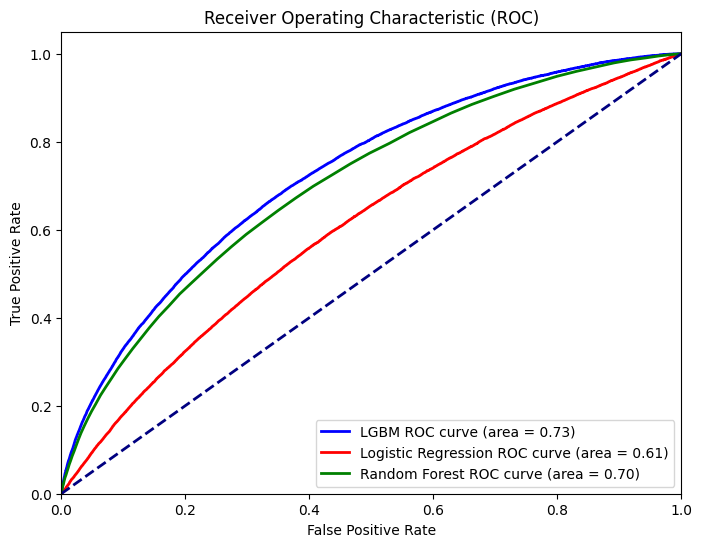

In [43]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
# 计算每个模型的 ROC 曲线和 AUC 值
#lgb
fpr_lgb, tpr_lgb, _ = roc_curve(y_test_lgb, y_probs_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)

#逻辑回归
fpr_lr, tpr_lr, _ = roc_curve(y_test_lr, y_probs_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

#随机森林
  # 转换为一维的标签数组
if y_test_rf.ndim > 1:
    y_test_rf_1d = y_test_rf.argmax(axis=1)
else:
    y_test_rf_1d = y_test_rf

  # 确保 y_prob_rf 是一维的概率数组
if y_probs_rf.ndim > 1:
    y_probs_rf_1d = y_probs_rf[:, 1]
else:
    y_probs_rf_1d = y_probs_rf

fpr_rf, tpr_rf, _ = roc_curve(y_test_rf_1d, y_probs_rf_1d)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr_lgb, tpr_lgb, color='blue', lw=2, label='LGBM ROC curve (area = %0.2f)' % roc_auc_lgb)
plt.plot(fpr_lr, tpr_lr, color='red', lw=2, label='Logistic Regression ROC curve (area = %0.2f)' % roc_auc_lr)
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label='Random Forest ROC curve (area = %0.2f)' % roc_auc_rf)

# 绘制对角线
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# 设置图形属性
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 综上所述，使用LGBM的模型进行训练和预测效果最好

In [47]:
# 将每个模型运行后 y 为 1 的概率数据输出为csv格式
pred_df = pd.DataFrame({
    'Id': range(1, len(X_test_lgb) + 1),
    'LightGBM_Probability': y_probs_lgb,
    'LogisticRegression_Probability': y_probs_lr,
    'RandomForest_Probability': y_probs_rf_1d
})

# 保存为 CSV
pred_df.to_csv('model_predictions.csv', index=False)